In [2]:
import OpenEXR
import Imath
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

# EXR Dataset Importing

In [8]:
class EXRDataset(Dataset):
    def __init__(self, root_dir, transform_input=None, transform_target=None):
        self.root_dir = Path(root_dir)
        self.inputs_dir = self.root_dir / "Inputs"
        self.targets_dir = self.root_dir / "Targets"

        # Gather sorted file paths
        self.input_paths = sorted(self.inputs_dir.glob("*.exr"))
        self.target_paths = sorted(self.targets_dir.glob("*.exr"))

        assert len(self.input_paths) == len(self.target_paths), \
            f"Number of inputs ({len(self.input_paths)}) and targets ({len(self.target_paths)}) must match."

        # Check filenames match
        for inp, tgt in zip(self.input_paths, self.target_paths):
            assert inp.name == tgt.name, \
                f"Mismatched file names: {inp.name} vs {tgt.name}"

        self.transform_input = transform_input
        self.transform_target = transform_target

        # Prepare OpenEXR pixel type for float32
        self.pt = Imath.PixelType(Imath.PixelType.FLOAT)

    def __len__(self):
        return len(self.input_paths)

    def _read_exr(self, path):
        exr_file = OpenEXR.InputFile(str(path))
        header = exr_file.header()
        dw = header['dataWindow']
        width = dw.max.x - dw.min.x + 1
        height = dw.max.y - dw.min.y + 1

        # Read channel data as binary strings
        rstr = exr_file.channel('R', self.pt)
        gstr = exr_file.channel('G', self.pt)
        bstr = exr_file.channel('B', self.pt)
        astr = exr_file.channel('A', self.pt)

        # Convert to float32 arrays and reshape to HxW
        r = np.frombuffer(rstr, dtype=np.float32).reshape(height, width)
        g = np.frombuffer(gstr, dtype=np.float32).reshape(height, width)
        b = np.frombuffer(bstr, dtype=np.float32).reshape(height, width)
        a = np.frombuffer(astr, dtype=np.float32).reshape(height, width)

        # Stack to CxHxW
        img = np.stack([r, g, b, a], axis=0)
        return img

    def __getitem__(self, idx):
        in_path = self.input_paths[idx]
        tgt_path = self.target_paths[idx]

        inp = self._read_exr(in_path)
        tgt = self._read_exr(tgt_path)

        # Convert to torch.Tensor, shape CxHxW
        inp_tensor = torch.from_numpy(inp).float()
        tgt_tensor = torch.from_numpy(tgt).float()

        # Apply optional transforms
        if self.transform_input:
            inp_tensor = self.transform_input(inp_tensor)
        if self.transform_target:
            tgt_tensor = self.transform_target(tgt_tensor)

        return inp_tensor, tgt_tensor


def plot_sample(dataset, idx):
    inp, tgt = dataset[idx]

    print(f"Input shape: {inp.shape}, Target shape: {tgt.shape}")
    
    # Convert to HWC numpy for plotting
    inp_np = inp.permute(1, 2, 0).numpy()
    tgt_np = tgt.permute(1, 2, 0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(np.clip(inp_np, 0.0, 1.0))
    axes[0].set_title("Input")
    axes[0].axis("off")

    axes[1].imshow(np.clip(tgt_np, 0.0, 1.0))
    axes[1].set_title("Target")
    axes[1].axis("off")

    plt.show()

def plot_sample_split(dataset, idx):
    inp, tgt = dataset[idx]
    # numpy arrays
    inp_np = inp.numpy()
    tgt_np = tgt.numpy()
    channels = ['R', 'G', 'B', 'A']

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    for i, ch in enumerate(channels):
        # Input channel visualization
        ax_in = axes[0, i]
        if ch in ['R', 'G', 'B']:
            cmap = None
            # Create colored image: zeros except channel
            img = np.zeros((inp_np.shape[1], inp_np.shape[2], 3), dtype=inp_np.dtype)
            img[..., i] = inp_np[i]
            ax_in.imshow(np.clip(img, 0.0, 1.0))
        else:
            # Alpha channel
            ax_in.imshow(np.clip(inp_np[3], 0.0, 1.0), cmap='gray')
        ax_in.set_title(f"Input {ch}")
        ax_in.axis('off')

        # Target channel visualization
        ax_tg = axes[1, i]
        if ch in ['R', 'G', 'B']:
            img = np.zeros((tgt_np.shape[1], tgt_np.shape[2], 3), dtype=tgt_np.dtype)
            img[..., i] = tgt_np[i]
            ax_tg.imshow(np.clip(img, 0.0, 1.0))
        else:
            ax_tg.imshow(np.clip(tgt_np[3], 0.0, 1.0), cmap='gray')
        ax_tg.set_title(f"Target {ch}")
        ax_tg.axis('off')

    plt.tight_layout()
    plt.show()

"""
path = Path("C:/Users/epuls/OneDrive/Desktop/Experiment1")
dataset = EXRDataset(path)
plot_sample(dataset, 0)
plot_sample_split(dataset, 0)
"""


'\npath = Path("C:/Users/epuls/OneDrive/Desktop/Experiment1")\ndataset = EXRDataset(path)\nplot_sample(dataset, 0)\nplot_sample_split(dataset, 0)\n'

In [35]:
class EXRSequenceDataset(Dataset):
    """
    PyTorch Dataset for loading RGBA EXR sequences from a single 'Inputs' folder.
    Sequences are grouped by integer prefix, with filenames like '0_0.exr', ..., '0_4.exr'.
    The last frame in each sequence is taken as the target.

    You can pass a single `transform` callable that takes (input_seq, target)
    and returns transformed (input_seq, target). This ensures any random
    operation (e.g., horizontal flip) is applied consistently across all
    frames and the target.

    output:
      - input_seq: Tensor of shape (T, 4, H, W)
      - target: Tensor of shape (4, H, W)
    """
    def __init__(self, root_dir, transform=None):
        self.inputs_dir = Path(root_dir) / "Inputs"
        self.transform = transform

        files = sorted(self.inputs_dir.glob("*.exr"))
        seq_dict = {}
        for f in files:
            stem = f.stem
            if '_' not in stem:
                continue
            prefix, idx = stem.split('_', 1)
            seq_dict.setdefault(int(prefix), []).append((int(idx), f))

        self.sequences = []
        for key in sorted(seq_dict):
            frames = sorted(seq_dict[key], key=lambda x: x[0])
            paths = [p for (_, p) in frames]
            if len(paths) > 1:
                self.sequences.append(paths)

        self.pt = Imath.PixelType(Imath.PixelType.FLOAT)

    def __len__(self):
        return len(self.sequences)

    def _read_exr(self, path):
        exr = OpenEXR.InputFile(str(path))
        dw = exr.header()['dataWindow']
        w, h = dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1
        chs = ['R', 'G', 'B', 'A']
        arr = []
        for c in chs:
            buf = exr.channel(c, self.pt)
            img = np.frombuffer(buf, dtype=np.float32).reshape(h, w)
            arr.append(img)
        return np.stack(arr, axis=0)

    def __getitem__(self, idx):
        paths = self.sequences[idx]
        inp_paths = paths[:-1]
        tgt_path = paths[-1]

        # Read sequence and target
        seq_np = [self._read_exr(p) for p in inp_paths]
        seq_np = np.stack(seq_np, axis=0)  # (T,4,H,W)
        tgt_np = self._read_exr(tgt_path)  # (4,H,W)

        seq = torch.from_numpy(seq_np).float()
        tgt = torch.from_numpy(tgt_np).float()

        # Apply joint transform if given
        if self.transform:
            seq, tgt = self.transform(seq, tgt)

        return seq, tgt

In [10]:
def plot_random_sequence(dataset):
    # pick random index
    idx = np.random.randint(len(dataset))
    seq, tgt = dataset[idx]  # seq: (T,4,H,W), tgt: (4,H,W)

    # Convert to HWC format for plotting
    seq_np = seq.permute(0, 2, 3, 1).numpy()  # (T,H,W,4)
    tgt_np = tgt.permute(1, 2, 0).numpy()     # (H,W,4)
    T = seq_np.shape[0]

    # Create subplot grid: 2 rows, T columns
    fig, axes = plt.subplots(2, T, figsize=(4 * T, 8))
    for t in range(T):
        # plot input frame
        ax_in = axes[0, t]
        ax_in.imshow(np.clip(seq_np[t], 0.0, 1.0))
        ax_in.set_title(f"Input Frame {t}")
        ax_in.axis('off')

        # plot target beneath each
        ax_tgt = axes[1, t]
        ax_tgt.imshow(np.clip(tgt_np, 0.0, 1.0))
        ax_tgt.set_title("Target")
        ax_tgt.axis('off')

    plt.tight_layout()
    plt.show()

#ds = EXRSequenceDataset(path)
#plot_random_sequence(ds)

# Data Loading

In [ ]:
def load_dataset(path, batch_size, train_split=0.8, val_split=0.1,
                  shuffle=True, print_validation=False):
    dataset = EXRDataset(path)
    total = len(dataset)
    if train_split + val_split >= 1.0:
        raise ValueError("train_split + val_split must be less than 1.0")

    train_len = int(train_split * total)
    val_len = int(val_split * total)
    test_len = total - train_len - val_len

    # Split dataset
    train_set, val_set, test_set = torch.utils.data.random_split(
        dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42)
    )

    # Create DataLoaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    if print_validation:
        for name, loader in zip(["Train", "Validation", "Test"], [train_loader, val_loader, test_loader]):
            dataset_len = len(loader.dataset)
            num_batches = len(loader)
            print(f"{name} set: {dataset_len} samples, {num_batches} batches, batch_size={loader.batch_size}")
            try:
                x, y = next(iter(loader))
                print(f"{name} batch shapes: inputs {x.shape}, targets {y.shape}")
            except StopIteration:
                print(f"{name} loader is empty.")

    return train_loader, val_loader, test_loader

# Example usage:
train_loader, val_loader, test_loader = load_dataset(path=path, batch_size=8, train_split=0.8, val_split=0.1, print_validation=True)

Train set: 400 samples, 50 batches, batch_size=8
Train batch shapes: inputs torch.Size([8, 4, 256, 256]), targets torch.Size([8, 4, 256, 256])
Validation set: 50 samples, 7 batches, batch_size=8
Validation batch shapes: inputs torch.Size([8, 4, 256, 256]), targets torch.Size([8, 4, 256, 256])
Test set: 50 samples, 7 batches, batch_size=8
Test batch shapes: inputs torch.Size([8, 4, 256, 256]), targets torch.Size([8, 4, 256, 256])


In [36]:
def load_sequence_dataset(path, batch_size, train_split=0.8, val_split=0.1,
                  shuffle=True, print_validation=False, transform=None):
    ds = EXRSequenceDataset(path, transform=transform)
    total = len(ds)
    if train_split + val_split >= 1.0:
        raise ValueError("train_split + val_split must be less than 1.0")

    n_train = int(total * train_split)
    n_val = int(total * val_split)
    n_test = total - n_train - n_val

    train_ds, val_ds, test_ds = torch.utils.data.random_split(
        ds, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(train_ds, batch_size=batch_size,
                              shuffle=shuffle)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size,
                              shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size,
                              shuffle=False)

    if print_validation:
        print(f"Total sequences: {total}")
        print(f"Train: {n_train} seqs, {len(train_loader)} batches, batch_size={batch_size}")
        print(f"Val:   {n_val} seqs, {len(val_loader)} batches, batch_size={batch_size}")
        print(f"Test:  {n_test} seqs, {len(test_loader)} batches, batch_size={batch_size}")
        for name, loader in zip(['Train','Val','Test'], [train_loader, val_loader, test_loader]):
            seq, tgt = next(iter(loader))
            print(f"{name} sample shapes: seq {seq.shape}, tgt {tgt.shape}")

    return train_loader, val_loader, test_loader

# Models

In [ ]:
class ConvLSTMCell(nn.Module):
    """
    Basic ConvLSTM cell.
    """
    def __init__(self, input_channels, hidden_channels, kernel_size, bias=True):
        super().__init__()
        padding = kernel_size // 2
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.conv = nn.Conv2d(
            in_channels=input_channels + hidden_channels,
            out_channels=4 * hidden_channels,
            kernel_size=kernel_size,
            padding=padding,
            bias=bias
        )

    def forward(self, input_tensor, prev_state):
        # prev_state: (h_cur, c_cur)
        h_cur, c_cur = prev_state
        combined = torch.cat([input_tensor, h_cur], dim=1)  # along channel axis
        conv_output = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(conv_output, self.hidden_channels, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

class ConvLSTM(nn.Module):
    """
    Multi-step ConvLSTM network.
    """
    def __init__(self, input_channels, hidden_channels, kernel_size, num_layers):
        super().__init__()
        assert len(hidden_channels) == num_layers, "hidden_channels must have length num_layers"
        assert len(kernel_size) == num_layers, "kernel_size must have length num_layers"

        self.num_layers = num_layers
        self.cells = nn.ModuleList()
        for i in range(num_layers):
            in_ch = input_channels if i == 0 else hidden_channels[i-1]
            self.cells.append(ConvLSTMCell(in_ch, hidden_channels[i], kernel_size[i]))

    def forward(self, input_seq):
        # input_seq: (batch, seq_len, channels, H, W)
        batch_size, seq_len, _, H, W = input_seq.size()
        h, c = [], []
        # initialize hidden states
        for i in range(self.num_layers):
            h.append(torch.zeros(batch_size, self.cells[i].hidden_channels, H, W, device=input_seq.device))
            c.append(torch.zeros(batch_size, self.cells[i].hidden_channels, H, W, device=input_seq.device))

        outputs = []
        for t in range(seq_len):
            x = input_seq[:, t]
            for i, cell in enumerate(self.cells):
                h[i], c[i] = cell(x, (h[i], c[i]))
                x = h[i]
            outputs.append(h[-1])
        # outputs: list of length seq_len of (batch, hidden_channels[-1], H, W)
        return torch.stack(outputs, dim=1)

class ConvLSTMNet(nn.Module):
    """
    Example network using ConvLSTM for single-step mapping of 4-channel input to 4-channel output.
    """
    def __init__(self, hidden_channels=[64, 64], kernel_size=[3, 3]):
        super().__init__()
        self.convlstm = ConvLSTM(
            input_channels=4,
            hidden_channels=hidden_channels,
            kernel_size=kernel_size,
            num_layers=len(hidden_channels)
        )
        # final 1x1 convolution to map hidden state to 4-channel output
        self.conv_out = nn.Conv2d(hidden_channels[-1], 4, kernel_size=1)

    def forward(self, input_tensor):
        # input_tensor: (batch, channels=4, H=256, W=256)
        # expand time dim
        x = input_tensor.unsqueeze(1)  # (batch, 1, 4, H, W)
        seq_output = self.convlstm(x)  # (batch, 1, hidden, H, W)
        last = seq_output[:, -1]       # (batch, hidden, H, W)
        out = self.conv_out(last)      # (batch, 4, H, W)
        return out

torch.Size([2, 4, 256, 256])


In [37]:
# ConvLSTM components
class ConvLSTMCell(nn.Module):
    def __init__(self, in_ch, hid_ch, k):
        super().__init__()
        pad = k//2
        self.hid_ch = hid_ch
        self.conv = nn.Conv2d(in_ch+hid_ch, 4*hid_ch, k, padding=pad)

    def forward(self, x, h, c):
        combined = torch.cat([x,h], dim=1)
        i,f,o,g = torch.chunk(self.conv(combined), 4, dim=1)
        i = torch.sigmoid(i); f = torch.sigmoid(f)
        o = torch.sigmoid(o); g = torch.tanh(g)
        c_next = f*c + i*g
        h_next = o*torch.tanh(c_next)
        return h_next, c_next

class ConvLSTM(nn.Module):
    def __init__(self, in_ch, hid_chs, ks):
        super().__init__()
        layers = []
        ch = in_ch
        for h,k in zip(hid_chs, ks):
            layers.append(ConvLSTMCell(ch, h, k))
            ch = h
        self.layers = nn.ModuleList(layers)
        self.hid_chs = hid_chs

    def forward(self, x):
        # x: (B, T, C, H, W)
        B,T,C,H,W = x.size()
        hs = [torch.zeros(B, h, H, W, device=x.device) for h in self.hid_chs]
        cs = [torch.zeros_like(h) for h in hs]
        for t in range(T):
            inp = x[:,t]
            for i,cell in enumerate(self.layers):
                hs[i],cs[i] = cell(inp, hs[i], cs[i])
                inp = hs[i]
        return hs[-1]

class ConvLSTMNet(nn.Module):
    """Sequence-to-1 frame predictor"""
    def __init__(self, hid_chs=[64,64], ks=[3,3]):
        super().__init__()
        self.lstm = ConvLSTM(4, hid_chs, ks)
        self.out = nn.Conv2d(hid_chs[-1], 4, 1)

    def forward(self, x):
        # x: (B, T, 4, H, W)
        h = self.lstm(x)
        return self.out(h)


In [24]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs, device, threshold=0.01):
    model.to(device)
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        total_pixels = 0
        correct_pixels = 0
        for seq, tgt in train_loader:
            seq = seq.to(device)
            tgt = tgt.to(device)
            optimizer.zero_grad()
            out = model(seq)
            loss = criterion(out, tgt)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * seq.size(0)
            diff = torch.abs(out - tgt)
            correct_pixels += (diff < threshold).float().sum().item()
            total_pixels += diff.numel()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct_pixels / total_pixels

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for seq, tgt in val_loader:
                seq = seq.to(device)
                tgt = tgt.to(device)
                out = model(seq)
                loss = criterion(out, tgt)
                val_loss += loss.item() * seq.size(0)
                diff = torch.abs(out - tgt)
                val_correct += (diff < threshold).float().sum().item()
                val_total += diff.numel()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train loss: {train_loss:.6f}, acc: {train_acc:.4f} | "
              f"Val loss: {val_loss:.6f}, acc: {val_acc:.4f}")

    return model

In [ ]:
def test_and_plot(model, test_loader, criterion, device, threshold=0.01, normFactor=10.0):
    model.to(device)
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0
    with torch.no_grad():
        for seq, tgt in test_loader:
            seq = seq.to(device)
            tgt = tgt.to(device)
            out = model(seq)
            loss = criterion(out, tgt)
            total_loss += loss.item() * seq.size(0)
            diff = torch.abs(out - tgt)
            total_correct += (diff < threshold).float().sum().item()
            total_pixels += diff.numel()
    test_loss = total_loss / len(test_loader.dataset)
    test_acc = total_correct / total_pixels
    print(f"Test loss: {test_loss:.6f}, accuracy: {test_acc:.4f}")

    # Plot a random sample from the first batch
    with torch.no_grad():
        seq_batch, tgt_batch = next(iter(test_loader))
        seq_batch = seq_batch.to(device)
        tgt_batch = tgt_batch.to(device)
        preds = model(seq_batch)

        # choose random index in batch
        b = seq_batch.size(0)
        idx = np.random.randint(b)
        seq = seq_batch[idx] * normFactor     # (T,4,H,W)
        tgt = tgt_batch[idx] * normFactor     # (4,H,W)
        pred = preds[idx] * normFactor        # (4,H,W)

        # convert to numpy
        T = seq.size(0)
        seq_np = seq.permute(0,2,3,1).cpu().numpy()  # (T,H,W,4)
        tgt_np = tgt.permute(1,2,0).cpu().numpy()     # (H,W,4)
        pred_np = pred.permute(1,2,0).cpu().numpy()   # (H,W,4)
        channels = ['R', 'G', 'B', 'A']

        # Create figure: 3 rows, 4 columns
        fig, axes = plt.subplots(3, 4, figsize=(16, 12))
        # Row 1: input frames
        for t in range(T):
            axes[0, t].imshow(np.clip(seq_np[t], 0.0, 1.0))
            axes[0, t].set_title(f"In {t}")
            axes[0, t].axis('off')
        # Row 2: target channels
        for c in range(4):
            ax = axes[1, c]
            ch = tgt_np[..., c]
            if c < 3:
                img = np.zeros((ch.shape[0], ch.shape[1], 3), dtype=ch.dtype)
                img[..., c] = ch
                ax.imshow(np.clip(img, 0.0, 1.0))
            else:
                ax.imshow(np.clip(ch, 0.0, 1.0), cmap='gray')
            ax.set_title(f"Target {channels[c]}")
            ax.axis('off')
        # Row 3: predicted channels
        for c in range(4):
            ax = axes[2, c]
            ch = pred_np[..., c]
            if c < 3:
                img = np.zeros((ch.shape[0], ch.shape[1], 3), dtype=ch.dtype)
                img[..., c] = ch
                ax.imshow(np.clip(img, 0.0, 1.0))
            else:
                ax.imshow(np.clip(ch, 0.0, 1.0), cmap='gray')
            ax.set_title(f"Pred {channels[c]}")
            ax.axis('off')
        plt.tight_layout()
        plt.show()

In [41]:
def normalize(seq, tgt):
    seq = seq/10
    tgt = tgt/10
    return seq, tgt
path = Path("C:/Users/epuls/OneDrive/Desktop/E1/")
train_loader, val_loader, test_loader = load_sequence_dataset(path, batch_size=4, transform=normalize,print_validation=True)
model = ConvLSTMNet().to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
trained = train_model(model, train_loader, val_loader, criterion, optimizer,
                       num_epochs=10, device='cuda')

Total sequences: 500
Train: 400 seqs, 100 batches, batch_size=4
Val:   50 seqs, 13 batches, batch_size=4
Test:  50 seqs, 13 batches, batch_size=4
Train sample shapes: seq torch.Size([4, 4, 4, 256, 256]), tgt torch.Size([4, 4, 256, 256])
Val sample shapes: seq torch.Size([4, 4, 4, 256, 256]), tgt torch.Size([4, 4, 256, 256])
Test sample shapes: seq torch.Size([4, 4, 4, 256, 256]), tgt torch.Size([4, 4, 256, 256])
Epoch 1/10 - Train loss: 0.013378, acc: 0.2786 | Val loss: 0.002569, acc: 0.4867
Epoch 2/10 - Train loss: 0.002228, acc: 0.5316 | Val loss: 0.001880, acc: 0.5770
Epoch 3/10 - Train loss: 0.001665, acc: 0.5482 | Val loss: 0.001468, acc: 0.5051
Epoch 4/10 - Train loss: 0.001246, acc: 0.5387 | Val loss: 0.001099, acc: 0.6317
Epoch 5/10 - Train loss: 0.000861, acc: 0.6231 | Val loss: 0.000662, acc: 0.6743
Epoch 6/10 - Train loss: 0.000685, acc: 0.6289 | Val loss: 0.000568, acc: 0.6476
Epoch 7/10 - Train loss: 0.000845, acc: 0.6088 | Val loss: 0.000814, acc: 0.4906
Epoch 8/10 - Trai

Test loss: 0.000421, accuracy: 0.7298


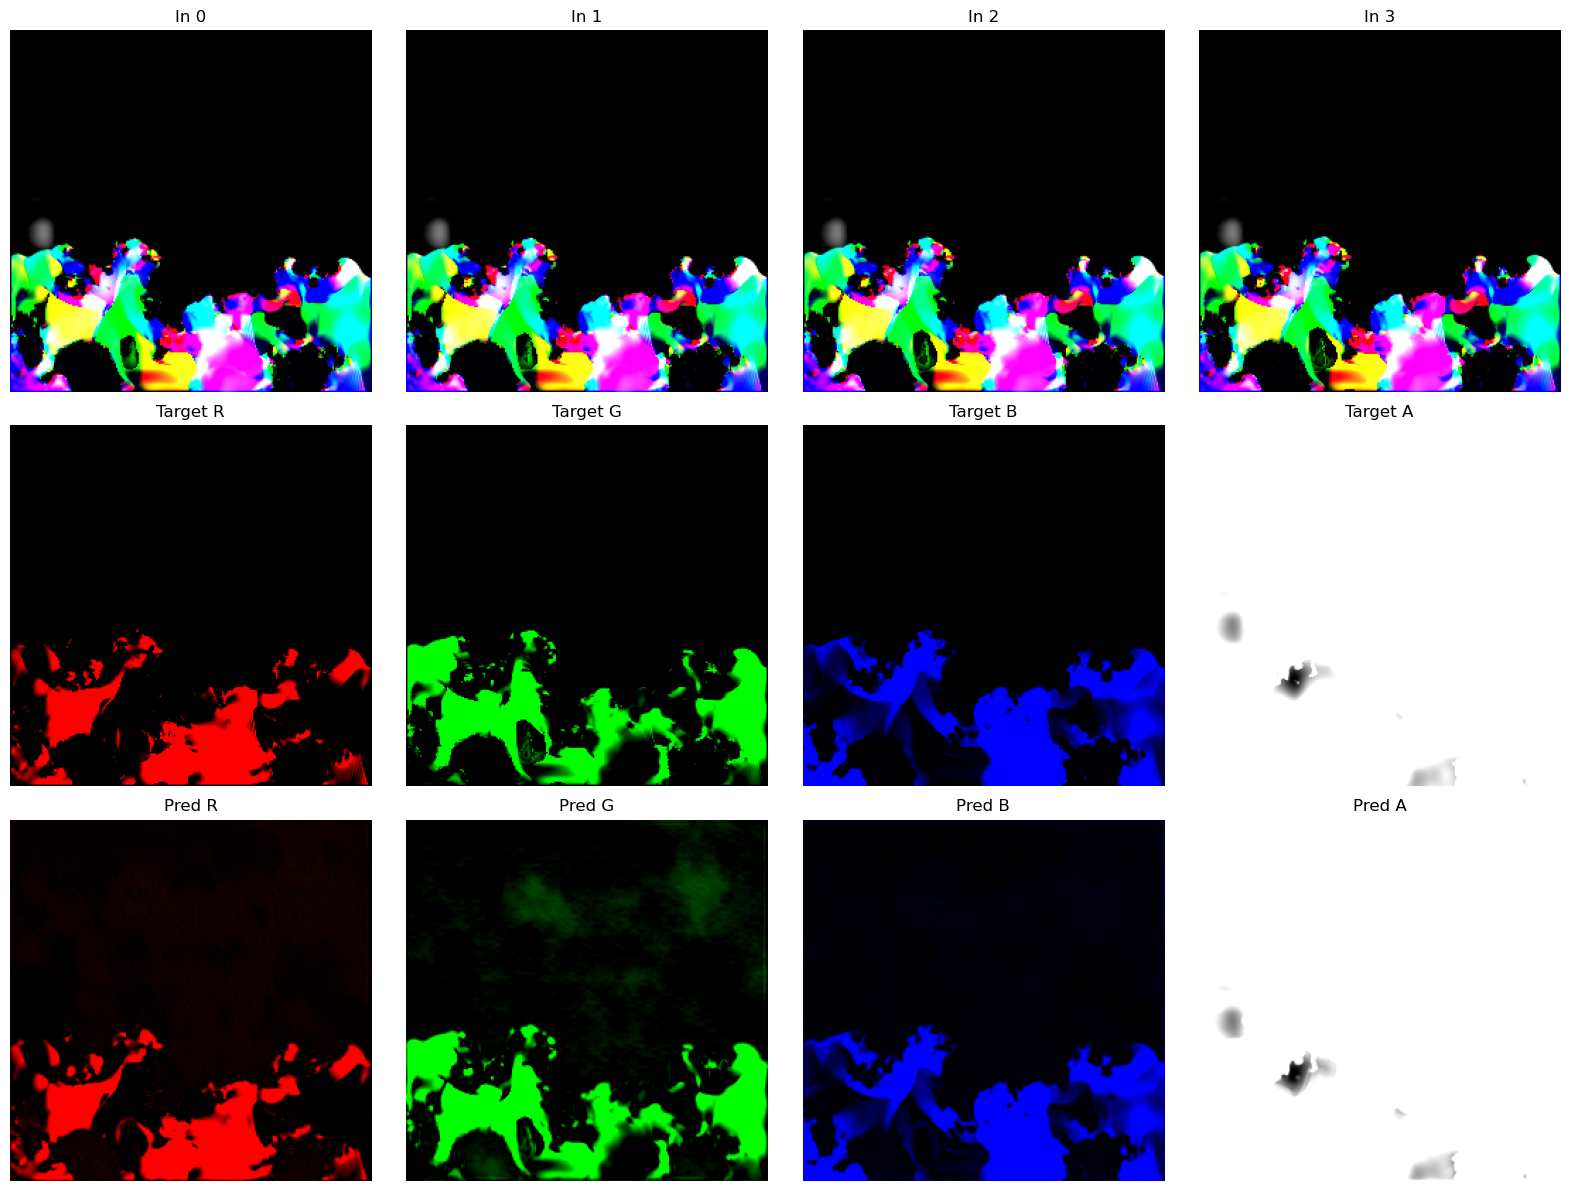

In [44]:
test_and_plot(trained, test_loader, criterion, device='cuda')

In [45]:
torch.save(trained, 'trained_model.pth')